# MDD 2022 Summer School: Data Security and Privacy for Outsourced Data in the Cloud (Lab Session)

Tristan Allard (Univ Rennes, CNRS, IRISA) & Amr El Abbadi (UC Santa Barbara)

_Acknowledgments to Louis Béziaud (Univ Rennes, CNRS, IRISA, UQÀM) and to Matthieu Simonin (INRIA)._

This work is licensed under a [Creative Commons Zero v1.0 Universal License](https://creativecommons.org/publicdomain/zero/1.0/)

# Step 0 (Starter)
<a id='step_0'></a>
This lab session is a lightweight introduction to <a href="https://hal.archives-ouvertes.fr/lirmm-01886725">PinedRQ</a> \[1\], an index over encrypted data designed so that probabilistic SIM-CDP, a computational variant of differential privacy, is satisfied. The notebook interface that you are currently reading will help you launch experiments and visualize the results. The metrics that we will monitor are `recall` and `precision` first (satisfying differential privacy leads to approximations in the query results), and time (encrypting records has an overhead).

\[1\] Cetin Sahin, Tristan Allard, Reza Akbarinia, Amr El Abbadi, Esther Pacitti. A Differentially Private Index for Range Query Processing in Clouds. 34th IEEE International Conference on Data Engineering (ICDE), Apr 2018, Paris, France. pp.857-868, ⟨10.1109/ICDE.2018.00082⟩.

## Step 1 (Technical preliminaries)
First, lets do some imports and setup the logger.

In [1]:
import logging

logging.basicConfig(level=logging.WARNING)

from itertools import product, groupby

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pinedrq


/home/tallard/.local/lib/python3.8/site-packages/pandas/compat/_optional.py:161: UserWarning: Pandas requires version '1.3.1' or newer of 'bottleneck' (version '1.2.1' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def random_query(frac: float, v_min: float, v_max: float):
    """
    Utility function for generating uniformly at random range queries.

    :param frac: Fraction of the domain considered.
    :param v_min: Min value of the domain.
    :param v_max: Max value of the domain
    """
    v_max -= 1 # We exclude the max element because it is not included in the leave.
    width = frac * (v_max - v_min)
    ge = np.random.randint(v_min, 1 + v_max - width)
    le = round(ge + width)
    return ge, le


def score(idx_pred: np.ndarray, idx_true: np.ndarray, ge: float, le: float):
    """
    Utility function for scoring the result of a query execution (recall and precision).

    :param idx_pred: The array of records retrieved through the cloud.
    :param idx_true: The array of records that would have been retrieved through the data manager (ground truth).
    :param ge: The lower bound of the range query (inclusive).
    :param le: The higher bound of the range query (inclusive).
    """

    tp = np.sum((idx_pred >= ge) & (idx_pred <= le))  # num true positives retrieved
    pp = len(idx_pred)  # total num records retrieved.
    pos = len(idx_true)  # total num of true positives in the ground truth.
    precision = tp / pp
    recall = tp / pos
    return precision, recall


def query_true(dm, ge, le):
    return dm.data[((dm.data[dm.index_col] >= ge) & (dm.data[dm.index_col] <= le))]

## Step 2 (Parameters)
We define below the number of repetitions per run that we will do and the parameters of the PinedRQ index. Do not hesitate to modify. You might need to modify the plots below in order to have a nice display.

In [3]:
repeats = 10  # num repeat each run

params = {
    "bins": [50],
    "degree": [5],
    "epsilon": np.logspace(start=-1, stop=2, num=4, endpoint=True),  # [10e-1 1 10e1 10e2]
    "proba_dp": np.linspace(start=0.5, stop=0.9, num=5, endpoint=True),  # [0.5 0.6 ... 0.9]
    "frac": [0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1],
}

## Step 3 (Measure)
We are now ready to launch the experiments by using the parameters defined above.

In [4]:
%%time
def run():
    for dm_args, params_ in groupby(product(*params.values()), key=lambda x: x[:4]):
        dm = pinedrq.DemoManager(*dm_args)
        cloud = pinedrq.Cloud(dm.index)
        client = pinedrq.Client(cloud, dm.keychain, dm.index_col)

        bounds = dm.data[dm.index_col].min(), dm.data[dm.index_col].max()

        *_, fracs = zip(*params_)

        for frac in fracs:
            for _ in range(repeats):
                ge, le = random_query(frac, *bounds)

                res = client.query(ge, le)
                if res is not None:
                    idx_pred = res[dm.index_col]
                else:
                    idx_pred = np.empty(0)  # catch nothing returned

                precision, recall = score(idx_pred, query_true(dm, ge, le), ge, le)

                yield *dm_args, frac, precision, recall

df = pd.DataFrame(run(), columns=[*params.keys(), "precision", "recall"])

CPU times: user 56 s, sys: 505 ms, total: 56.5 s
Wall time: 57.3 s


## Step 4 (Visualize and analyze)

Finally, we visualize the measures that we have just performed by printing and plotting them. Do not hesitate to change or add graphs that can assist you in your analysis.

In [5]:
# df.describe() # Uncomment if you want to display general statistics about the results.

4*5


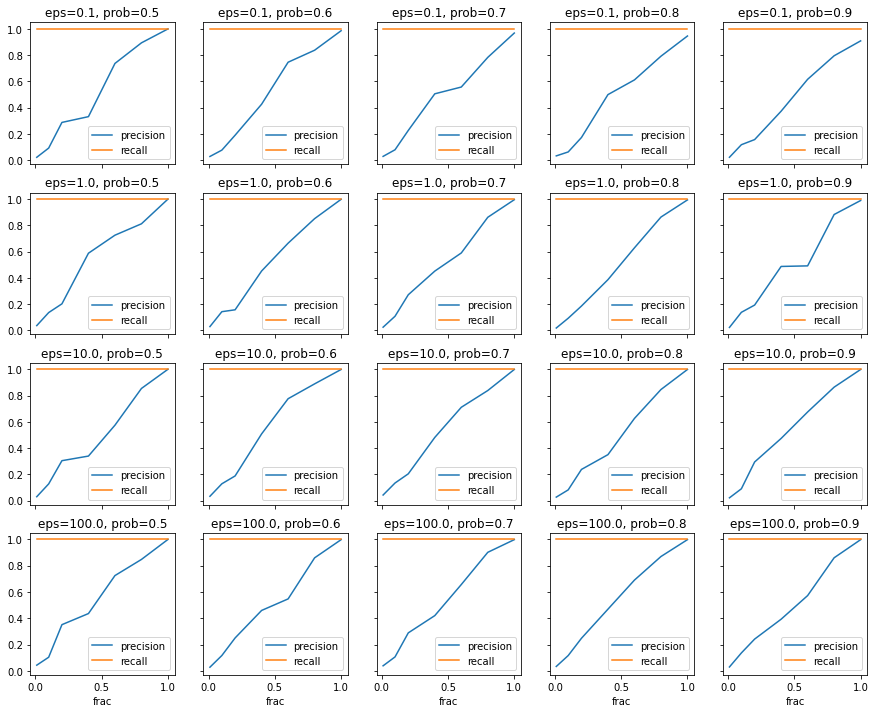

In [6]:
dfm = (
    df.groupby(["bins", "degree", "epsilon", "proba_dp", "frac"]).mean().reset_index(-1)
)

ncols = 5
nrows = dfm.index.nunique() // ncols
if dfm.index.nunique() % ncols > 0:
    nrows += 1

print(f"{nrows}*{ncols}")

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(3 * ncols, 3 * nrows), sharex=True, sharey=True
)

for ax, (gname, gdf) in zip(axes.flat, dfm.groupby(dfm.index)):
    ax.set_title(f"eps={gname[2]:.1f}, prob={gname[3]:.1f}")
    gdf.plot(x="frac", ax=ax, legend=True)

## Step 4 (Analysis)
Analyse the variations of your measures given the parameters under study. What are your conclusions ?

`TODO: We can observe that [....]`